# Homework 10: Neural Networks
by Yousif Khaireddin

**Due date**: April 28, Wednesday by 11:59pm


## Setup

To run and solve this assignment, you must have access to a working Jupyter Notebook installation. We recommend Google Colab. If you are already familiar with Jupyter and have your own installation, you may use it; however, you will have to tweak Colab-specific commands we've entered here (for example, file uploads).

To use Google Colab:

1. Download this `ipynb` file.
2. Navigate to https://colab.research.google.com/ and select `Upload` in the pop-up window.
3. Upload this file. It will then open in Colab.

The below statements assume that you have already followed these instructions. If you need help with Python syntax, NumPy, or Matplotlib, you might find Week 1 discussion material useful.

To run code in a cell or to render Markdown+LaTeX press Ctrl+Enter or "`Run`" button above. To edit any code or text cell, double-click on its content. Put your solution into boxes marked with **`[double click here to add a solution]`** and press Ctrl+Enter to render text. You can add cells via `+` sign at the top left corner.

**Submission instructions**: please upload your completed solution file as well as a scan of any handwritten answers to Gradescope by **April 28th at midnight**..

## **Question 1:** Useful Functions and Setup


In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Loading Dataset

Using the datasets module within torchvision, download the MNIST dataset.
1. Download both the training dataset as well as the testing dataset.
2. Using _torch.utils.data.random_split_ seperate the training dataset into 50000 training samples and 10000 validation samples 

In [3]:
# Training and validation data
train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
print(train_dataset)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(42))# CODE
print(train_dataset)
# Testing data
test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!
Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
print("Number of Training Samples:", len(train_dataset), sep='\t')
print("Number of Validation Samples:", len(val_dataset), sep='\t')
print("Number of Testing Samples:", len(test_dataset), sep='\t')

Number of Training Samples:	50000
Number of Validation Samples:	10000
Number of Testing Samples:	10000


Build your dataloaders using the datasets above. Make sure to use a batchsize of 64 and to shuffle your dataset.

In [5]:
# Creating Dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True) # CODE
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)# CODE
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)# CODE

print("Number of Training Batches:", len(trainloader), sep='\t')
print("Number of Validation Batches:", len(valloader), sep='\t')
print("Number of Testing Batches:", len(testloader), sep='\t')

Number of Training Batches:	782
Number of Validation Batches:	157
Number of Testing Batches:	157


### Important functions

Complete the function `train(net, dataloader, criterion, optimizer)` which will train a given network for 1 whole epoch using a given dataloader.

This function will iterate through the dataloader, compute the network outputs, the loss, backpropagage to update the networks weights, and return the accuracy and average loss across the dataloader

Ensure to setup the network in training mode using the .train() attribute built by pytorch.

In [6]:
def train(net, dataloader, criterion, optimizer):
    net = net.train()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        # CODE
        optimizer.zero_grad()
        
        # forward + backward + optimize
        # CODE
        output = net.forward(inputs)
        L= criterion(output, labels)
        L.backward()
        optimizer.step()
        # store / calculate performance metrics (acc, loss)
        # CODE
        #straight from the tutorial 
        _, predicted = torch.max(output.data, 1)
        n_samples += labels.size(0)
        correct_count += (predicted == labels).sum().item()
        loss_tr = loss_tr + L.item()
        
    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples

    return acc, loss

Complete the function `evaluate(net, dataloader, criterion)` which will evauate a given network's performance across a given dataloader

This function will iterate through the dataloader, compute the network outputs, the loss, and return the accuracy and average loss across the dataloader.

Ensure to setup the network in validation mode using the .eval() attribute built by pytorch.

In [7]:
def evaluate(net, dataloader, criterion):
    net = net.eval()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # compute network predictions
        # CODE
        output = net.forward(inputs)
        L= criterion(output, labels)
        
        # calculate performance metrics (acc, loss)
        # CODE
        _, predicted = torch.max(output.data, 1)
        n_samples += labels.size(0)
        correct_count += (predicted == labels).sum().item()
        loss_tr = loss_tr + L.item()
        
    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples

    return acc, loss

Complete the function `count_parameters(model)` which should count the number of trainable parameters in a network.

In [8]:
def count_parameters(model):
    sumof = 0.0
    for i in model.parameters():
      if(i.requires_grad):
        sumof +=i.numel()
    count = sumof
    return count

The following function will be used to create plots of your performance metrics.


In [9]:
def plot_metrics(train_acc, train_loss, val_acc, val_loss):
    plt.figure()
    plt.plot(train_acc, 'g', label='Training Acc')
    plt.plot(val_acc, 'b', label='Validation Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(train_loss, 'g', label='Training Loss')
    plt.plot(val_loss, 'b', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

## **Question 2:** Dense Networks

**Note:**
In solving the following sections, it is possible very likely that your results do not match ours exactly. This is due to the randomization in initilizations. What is important is that they are within the margins we set when defining the problem. 

### Initial Performance

Recall from the discussion session, we provided you with the following fully connected (dense) network.


In [10]:
class Dense(nn.Module):
    # What does your model contain
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        
        self.fc4 = nn.Linear(64, 10)    # 10 classes
    
    # This is how data moves when passed to your model
    def forward(self, x):
        x = x.view(-1, 28*28)   # Flatten
        x = F.relu(self.fc1(x)) # Pass through layers
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = F.log_softmax(self.fc4(x), dim=1)   # soft max 
      
        return x

dense = Dense().to(device)

print("Model Architecture")
print("Number of parameters:", count_parameters(dense))

Model Architecture
Number of parameters: 59210.0


Complete the following code to train the network above for 3 epochs.
1. For your optimizer, use stochatic gradient descent with a learning rate of 0.001
2. For your criterion (loss function) use Cross Entropy Loss (the one built by pytorch)

**Note:** We are expecting bad performance here using the above mentioned parameters.

In [11]:
optimizer =optim.SGD(dense.parameters(), lr=0.001) # CODE
criterion = nn.CrossEntropyLoss() # CODE

train_acc, train_loss = [],[]
val_acc, val_loss = [],[]

print("Training on", device)
for epoch in range(3):
    
    acc_tr, loss_tr = train(dense, trainloader, criterion, optimizer)
    train_loss.append(loss_tr)
    train_acc.append(acc_tr)

    acc_v, loss_v = evaluate(dense, valloader, criterion)
    val_loss.append(loss_v)
    val_acc.append(acc_v)

    print('Epoch %2d' % (epoch + 1),
            'Train Accuracy: %2.2f %%' % acc_tr,
            'Val Accuracy: %2.2f' % acc_v,
            sep='\t\t')

Training on cuda:0
Epoch  1		Train Accuracy: 9.64 %		Val Accuracy: 10.12
Epoch  2		Train Accuracy: 10.63 %		Val Accuracy: 11.73
Epoch  3		Train Accuracy: 13.17 %		Val Accuracy: 16.42


Plot your peroformance using `plot_metrics` then evaluate your performance on the testloader / testset



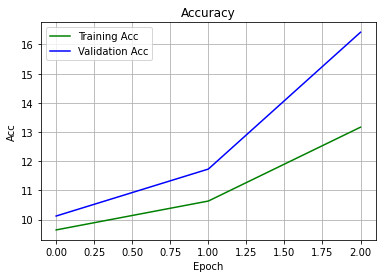

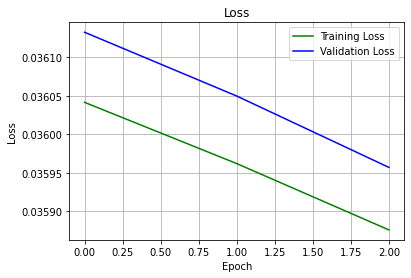

Test Accuracy: 16.20 %		Test Loss: 0.035952


In [12]:
plot_metrics(train_acc, train_loss, val_acc, val_loss)

acc_test, loss_test =  evaluate(dense, testloader, criterion)# CODE
print('Test Accuracy: %2.2f %%' % acc_test,
        'Test Loss: %2.6f' % loss_test,
        sep='\t\t')

### Tuned Performance

Vary any parameters you would like in the model's architecture (number of layers, hidden units, activation functions) or the training parameters (number of epochs, optimizer, learning rate, weight decay, momentum) to improve your initial performance. 

**Notes and requirements:** 
- The minimum acceptable test accuracy is 90%
- If you run your network multiple times it is possible to get very different results with each run. This is due to the random initializations.
- You are required to note down 5 significant changes you have experimented with and explain how these changes impacted your performance and your understanding as to why this is the case.
- Keep your best performing model / training method and create the same plots and testing performance from above. 

In [13]:
class TunedDense(nn.Module):
    # What does your model contain
    def __init__(self):
        # CODE
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)   
    # This is how data moves when passed to your model
    def forward(self, x):
        # CODE 
        x = x.view(-1, 28*28)   # Flatten
        x = F.relu(self.fc1(x)) # Pass through layers
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x)) 

        x = F.log_softmax(self.fc4(x), dim=1) 
        return x

tuned_dense = TunedDense().to(device)

print("Model Architecture")
print(tuned_dense)
print("Number of parameters:", count_parameters(tuned_dense))

Model Architecture
TunedDense(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)
Number of parameters: 67530.0


In [14]:
optimizer =optim.SGD(tuned_dense.parameters(), lr=0.01, momentum=0.4) # CODE 
criterion = nn.CrossEntropyLoss() # CODE

train_acc, train_loss = [],[]
val_acc, val_loss = [],[]

print("Training on", device)
for epoch in range(11):
    
    acc_tr, loss_tr = train(tuned_dense, trainloader, criterion, optimizer)
    train_loss.append(loss_tr)
    train_acc.append(acc_tr)

    acc_v, loss_v = evaluate(tuned_dense, valloader, criterion)
    val_loss.append(loss_v)
    val_acc.append(acc_v)

    print('Epoch %2d' % (epoch + 1),
            'Train Accuracy: %2.2f %%' % acc_tr,
            'Val Accuracy: %2.2f' % acc_v,
            sep='\t\t')

Training on cuda:0
Epoch  1		Train Accuracy: 11.03 %		Val Accuracy: 11.29
Epoch  2		Train Accuracy: 11.64 %		Val Accuracy: 16.47
Epoch  3		Train Accuracy: 28.74 %		Val Accuracy: 51.72
Epoch  4		Train Accuracy: 68.02 %		Val Accuracy: 80.35
Epoch  5		Train Accuracy: 85.97 %		Val Accuracy: 88.01
Epoch  6		Train Accuracy: 90.08 %		Val Accuracy: 90.92
Epoch  7		Train Accuracy: 92.29 %		Val Accuracy: 92.17
Epoch  8		Train Accuracy: 93.74 %		Val Accuracy: 93.11
Epoch  9		Train Accuracy: 94.63 %		Val Accuracy: 94.08
Epoch 10		Train Accuracy: 95.27 %		Val Accuracy: 93.84
Epoch 11		Train Accuracy: 95.73 %		Val Accuracy: 94.11


Plot your peroformance using `plot_metrics` then evaluate your performance on the testloader / testset



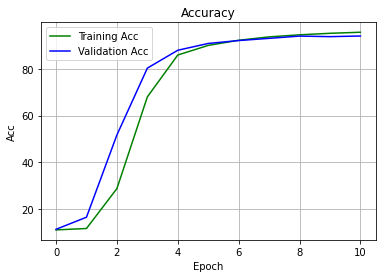

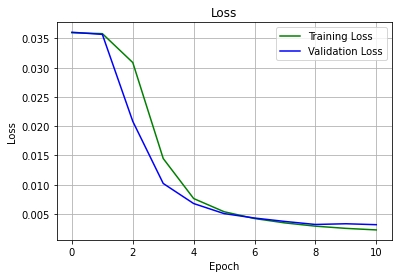

Test Accuracy: 94.32 %		Test Loss: 0.003002


In [15]:
plot_metrics(train_acc, train_loss, val_acc, val_loss)

acc_test, loss_test = evaluate(tuned_dense, testloader, criterion)# CODE
print('Test Accuracy: %2.2f %%' % acc_test,
        'Test Loss: %2.6f' % loss_test,
        sep='\t\t')

**Experiementations and explainations:**

*   Fiddled with the learning rate
*   added mommentum param to sgd 
*   added more layers 
*   increased the number of epocs 
*   changed the momentum. 
*   a non linear activation function would have been cool but most of this came because I went deep and found a better learning rate.  




## **Question 3:** Convolutional  Neural Networks



Using pytorch, build a 2d convolutional neural network with the following architecture.

1. 2D Convolution mapping the 1 x L x W input to 64 feature maps
2. 2D Convolution mapping the 64 x L x W features to 32 feature maps

3. Flatten the output
3. A dense layer mapping the flattened output to 16 nodes
4. A final dense layer mapping the 16 nodes to 10 classes

Each convolutional layer should be followed by a relu activation function then a 2D maxpool of `kernel_size` 2 and `stride` of 2

Each dense layer should be followed by a relu activation

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # # CODE
        # self.conv1 = nn.Conv2d(1, 64, 2) use k 3 and padding 1 because it wont change the size of image

        # self.fc1 = nn.Linear((32 *2 * 2), 16)  # 28*28 from image dimension
    
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(64, 32, 3)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(800, 84)
        self.fc3 = nn.Linear(84, 16)
        self.fc2 = nn.Linear(16, 10)
        # an affine operation: y = Wx + b check max mpooling doc 

        
        
    def forward(self, x):
        # CODE
        x = self.pool1(F.relu(self.conv1(x)))

        x = self.pool2(F.relu(self.conv2(x)))



        x = x.view(-1, 800)

        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc2(x))

        x = F.log_softmax(x, dim=1)

        return x
  
cnn = CNN().to(device)

print("Model Architecture")
print(cnn)
print("Number of parameters:", count_parameters(cnn))

Model Architecture
CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)
Number of parameters: 87918.0


Complete the following code to train the network above for 10 epochs.
1. For your optimizer, use stochatic gradient descent (you may change this later if you would like)

2. For your criterion (loss function) use Cross Entropy Loss (the one built by pytorch)

**Notes and requirements:** 
- The minimum acceptable test accuracy is 90%
- If you run your network multiple times it is possible to get very different results with each run. This is due to the random initializations.
- You are welcome to experiment with the CNN architecture and anything else you want. You are required to experiment with different values for `learning_rate`, `momentum`, and `weight_decay` in your optimizer to improve your performance.
- Note down your experimentations and explain how these changes impacted your performance and your understanding as to why this is the case.
- Keep your best performing model / training method and create the same plots and testing performance as before.

In [17]:
optimizer = optim.SGD(cnn.parameters(), lr=0.15, momentum=0.5)# CODE
criterion = nn.CrossEntropyLoss()# CODE

train_acc, train_loss = [], []
val_acc, val_loss = [], []

print("Training on", device)
for epoch in range(10):
    
    acc_tr, loss_tr = train(cnn, trainloader, criterion, optimizer)
    train_loss.append(loss_tr)
    train_acc.append(acc_tr)

    acc_v, loss_v = evaluate(cnn, valloader, criterion)
    val_loss.append(loss_v)
    val_acc.append(acc_v)

    print('Epoch %2d' % (epoch + 1),
            'Train Accuracy: %2.2f %%' % acc_tr,
            'Val Accuracy: %2.2f' % acc_v,
            sep='\t\t')

Training on cuda:0
Epoch  1		Train Accuracy: 87.40 %		Val Accuracy: 97.39
Epoch  2		Train Accuracy: 98.17 %		Val Accuracy: 96.55
Epoch  3		Train Accuracy: 98.68 %		Val Accuracy: 98.11
Epoch  4		Train Accuracy: 99.05 %		Val Accuracy: 98.60
Epoch  5		Train Accuracy: 99.24 %		Val Accuracy: 98.89
Epoch  6		Train Accuracy: 99.41 %		Val Accuracy: 98.22
Epoch  7		Train Accuracy: 99.53 %		Val Accuracy: 98.69
Epoch  8		Train Accuracy: 99.61 %		Val Accuracy: 98.82
Epoch  9		Train Accuracy: 99.63 %		Val Accuracy: 98.93
Epoch 10		Train Accuracy: 99.73 %		Val Accuracy: 98.79


Plot your peroformance using `plot_metrics` then evaluate your performance on the testloader / testset

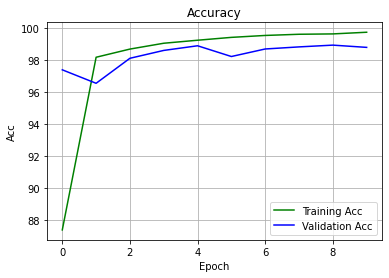

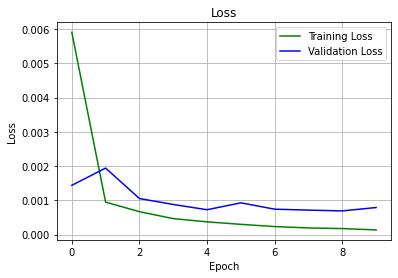

Test Accuracy: 98.79 %		Test Loss: 0.000792


In [18]:
plot_metrics(train_acc, train_loss, val_acc, val_loss)

acc_test, loss_test = evaluate(cnn, valloader, criterion) # CODE
print('Test Accuracy: %2.2f %%' % acc_test,
        'Test Loss: %2.6f' % loss_test,
        sep='\t\t')

**Experiementations and explainations:**

I tried a lot to get this  to work. 
 * I tried changing the convultional layers kernal size.
 * I tried adjusting the linear layers a bit but there wasnt a tone of diff.
 * I tried messing with the max pooling kernal size, but I would always break it. (honestly I can still never figure out the correct dimentions of the image im working with so I just do the error missmach value /64 to get my desired result. hmm maybe I could have just done (64, -1) ehh)
 * I made the learning rate more agressive, honestly only positive things have come from that in this hw 
 * I added some weight decay but for any value I tried it would bring down accuracy  
 * I increased momentum. 


## **Question 4:** Compare your results


Compare the cnn and dense networks your have built in terms of performance, runtime, accuracy, and any other factors you think are note worthy.



```
# This is formatted as code
```

**Answer:**

Based on what we learned in class im pretty sure that the convolutional NN did bettter, however, I think that my example of a CNN benefited from me doing so much testing. In general it seems like my CNN is slower at each layer but it is faster i terms of epochs it also the CNN's accuracy was consistently higher than any of the other NN I have made with pytorch. I if I had to guess I would say that the CNN was more computationally intesive. This is mostly because of the image parsing which seems like its diffucult to optomize and the large matrix that are used in the linear step. 
  
